In [0]:
!pip install PyDrive

import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#TEST
downloaded = drive.CreateFile({'id':"1VccJxz7w_W8srYA-UDRURCujwaWhhPcq"})   # replace the id with id of file you want to access
downloaded.GetContentFile('test.csv')
test_df = pd.read_csv('test.csv')
#TRAIN
downloaded = drive.CreateFile({'id':"1gwiV6F28tV0OdWWWbIsm_kY-NibNBPb7"}) 
downloaded.GetContentFile('train.csv')
train_df = pd.read_csv('train.csv')

# Load in datasets

In [0]:

train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [0]:

test_df.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-0.484619,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-0.723642,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-0.898000,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.9682

# Create concatinated dataframe

The dataset where already divided and split into a train and test set, but to have more controll during the process of feature selection and to be able to divide the dataset using the stratify option to make sure the distribution over the labels is uniform, the group decided to concatinate the sets and later split them later in the process.

In [0]:
# dimesions of dataframes
print("Dimensions of original training set:", train_df.shape)
print("Dimensions of original testing set:", test_df.shape)

# controlling what the new dimension should be
new = int(train_df.shape[0]) + int(test_df.shape[0]) 

# concatinating dataframes
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)



print("New dimension of dataframe",df.shape)

Dimensions of original training set: (7352, 563)
Dimensions of original testing set: (2947, 563)
New dimension of dataframe (10299, 563)


In [0]:
# Looking if dataset is complete
df.isnull().values.any()

False

# Exploring the features

In [0]:
df.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,-0.305180,-0.562230,0.525304,0.389537,0.598022,-0.552087,-0.825460,-0.902704,-0.854662,-0.689162,-0.643512,-0.640686,-0.100332,-0.128765,-0.157863,-0.118954,0.108574,-0.035699,0.122000,-0.029677,0.031724,0.155148,-0.018077,0.006110,0.037729,0.034424,-0.082669,-0.120309,-0.197746,0.102199,...,-0.676629,-0.338469,-0.877800,0.173220,-0.298598,-0.601659,-0.697411,-0.699976,-0.681014,-0.734623,-0.888701,-0.697411,-0.881301,-0.722125,-0.076279,-0.886999,-0.041564,-0.264279,-0.575866,-0.779768,-0.792190,-0.773404,-0.809934,-0.871201,-0.779768,-0.937898,-0.772715,-0.274339,-0.900033,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284,16.146422
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,0.279920,0.282991,0.356589,0.338844,0.290615,0.461375,0.247052,0.125988,0.205998,0.359209,0.368865,0.372065,0.462315,0.433687,0.3

In [0]:
count_dict = {}

for col in df.columns:
    #print(col)
    cat = col.split('-')[0].split('(')[0]
    #print(cat)
    
    if cat in count_dict.keys():
        count_dict[cat] += 1
        #print(count_dict[cat])
    
    else:
        count_dict[cat] = 1
    

count_df = pd.DataFrame.from_dict(count_dict, orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)
count_df

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


## Subject feature

The subject is representing the each person participating while collecting the data, we therefore make it a string object.

In [0]:
subject_list = list((df["subject"].unique()))
subject_list.sort()
print(subject_list)

df['subject'] = '#' + df['subject'].astype(str)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


## Exploring the labels


In [0]:
unique = df["Activity"].unique()
print(unique)


['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64


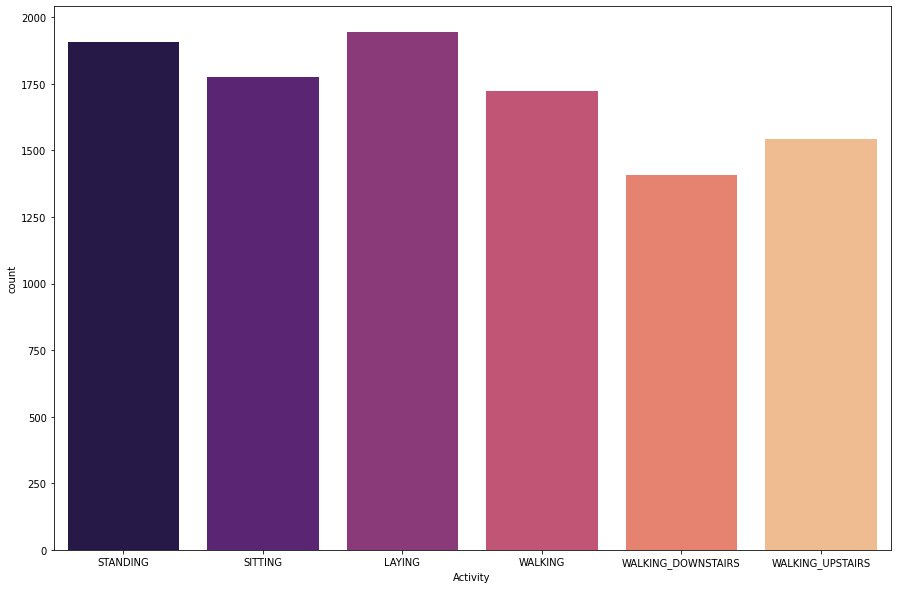

In [0]:
label = df['Activity']

label_count = label.value_counts()
print(label_count)

plt.figure(figsize=(15,10)) # this creates a figure 8 inch wide, 4 inch high
sns.countplot(x=df['Activity'], palette="magma")
plt.show()


The labels seems to be closer towards a uniform distribution

In [0]:
       
label_means = pd.DataFrame(columns=df["Activity"].unique())

for c, rows in df.drop("subject", axis=1).groupby('Activity'):
    label_means[c] = rows.mean()
      



In [0]:
label_means.sample(20)


,STANDING,SITTING,LAYING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
"fBodyAccJerk-bandsEnergy()-17,32",-0.999004,-0.999439,-0.999085,-0.667956,-0.560612,-0.804091
fBodyAccJerk-min()-Y,-0.980859,-0.984817,-0.984050,-0.689197,-0.691916,-0.756079
tBodyAcc-entropy()-Y,-0.421356,-0.457787,-0.530032,0.294771,0.318817,0.236379
"fBodyAcc-bandsEnergy()-1,8.2",-0.991940,-0.987796,-0.988956,-0.764811,-0.735299,-0.588947
fBodyAcc-min()-Y,-0.976843,-0.964303,-0.971879,-0.762107,-0.749214,-0.799829
tBodyGyro-max()-Y,-0.927637,-0.935063,-0.935015,-0.492322,-0.469632,-0.547276
tBodyAccJerkMag-sma(),-0.977118,-0.982444,-0.979209,-0.241452,-0.111802,-0.390939
tBodyGyro-max()-Z,-0.724472,-0.731206,-0.715996,-0.227158,-0.151910,-0.200658
fBodyAccJerk-kurtosis()-Y,-0.864316,-0.867167,-0.875929,-0.711055,-0.803147,-0.798116
"fBodyAcc-bandsEnergy()-25,32.2",-0.999359,-0.999379,-0.999199,-0.912263,-0.872301,-0.962474


## Corealtion and discarding corealted features

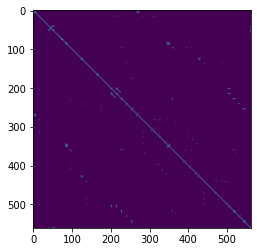

In [0]:
PC = df.copy()
PC = df.drop(["Activity", 'subject'], axis=1).corr()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(abs(PC)>0.99)


In [0]:
df.drop(["Activity", 'subject'], axis=1).corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)


In [0]:
# Create correlation matrix
corr_matrix = df.drop(["Activity",'subject'], axis=1).corr()

# Select upper triangle of correlation matrix
first = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Threshold
drop_list = [column for column in first.columns if any(first[column] > 0.99)]

# Remove redudant features 
df.drop(drop_list, axis=1, inplace=True)
print(df.shape)

In [0]:
PC = df.copy()
PC = df.drop(["Activity",'subject'], axis=1).corr()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(abs(PC)>0.99)


In [0]:
print(563-449)

In [0]:
df.drop(["Activity",'subject'], axis=1).corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)


In [0]:
count_dict = {}

for col in df.columns:
    #print(col)
    cat = col.split('-')[0].split('(')[0]
    #print(cat)
    
    if cat in count_dict.keys():
        count_dict[cat] += 1
        #print(count_dict[cat])
    
    else:
        count_dict[cat] = 1
    
#print(count_dict)

count_df = pd.DataFrame.from_dict(count_dict, orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)
count_df

# Label Encoder

In [0]:
df["Activity"].head()
        

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Activity"] = le.fit_transform(df.Activity)

df["Activity"].head()

In [0]:
mapper_dict = {}
unique_encode_list = list(df["Activity"].unique())

for i in range(6):
    mapper_dict[unique_encode_list[i]] = unique[i]
    
print(mapper_dict)

In [0]:


X = np.array(df.drop(["Activity",'subject'], 1))
y = np.array(df["Activity"])

print(X.shape)
print(y.shape)



# PCA

Compute the covariance matrix $\mathbf{C}$ of the dimensions in the dataset, and perform an eigenvector decomposition of it, $\mathbf{C} = \mathbf{Q}\mathbf{\Lambda}\mathbf{Q}^T$. 

np.linalg.eig = Compute the eigenvalues and right eigenvectors of a square array.


In [0]:
Covariance = df.drop(["Activity", "subject"], axis=1).cov()

C = Covariance
print(C.shape)

eigenValues, eigenVectors = np.linalg.eig(C)

In [0]:
#print(eigenValues)

# Plot Eigenvalues

Plot the eigenvalues, i.e., the diagonal elements of $\mathbf{\Lambda}$. 

In [0]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(eigenValues)
plt.xticks(np.arange(1,562,1))
plt.ylabel('Eigenvalue')
plt.xlabel('Principal direction')
plt.xlim((0, 20))
plt.ylim((0,20))
plt.title("Eigenvalues and Principal Direction")
ax.grid()

plt.show()

In [0]:
# SAME PLOT BUT MORE ZOOMED IN

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(eigenValues)
plt.xticks(np.arange(1,562,1))
plt.ylabel('Eigenvalue')
plt.xlabel('Principal direction')
plt.xlim((0, 10))
plt.ylim((0, 6))
plt.title("Eigenvalues and Principal Direction")
ax.grid()

plt.show()

### Result 
Seems like a feature selection of 3 or 5 is a good number to work with

# Plot Eigenvectors



In [0]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(range(len(eigenValues)),eigenVectors[:,0:2])
plt.xticks(ticks = range(len(eigenValues)), labels=df.columns,rotation=80)
ax.legend(labels=['PD1','PD2'])
plt.ylabel('Value')
plt.xlim((0, 50))
plt.ylim((-0.2,0.2))
ax.grid()
plt.show()

## Project the mean-centered observations of the dataset onto the two eigenvectors PD1, PD2

In [0]:
    
Xproj = np.dot(np.real(eigenVectors).T,(X-X.mean(axis=0)).T).T

import matplotlib.cm as cm

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(Xproj[:,0],Xproj[:,1],alpha=0.5, c=y, cmap=plt.cm.magma, s=20)
plt.xlabel('PD1')
plt.ylabel('PD2')
ax.grid()
plt.show()



## PD2, PD3


In [0]:
    
Xproj = np.dot(np.real(eigenVectors).T,(X-X.mean(axis=0)).T).T

#Xproj = np.dot(eigenVectors.T[:,(0,1)],(X-X.mean(axis=0)).T).T


import matplotlib.cm as cm

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(Xproj[:,1],Xproj[:,2],alpha=0.5, c=y, cmap=plt.cm.magma, s=20)
plt.xlabel('PD2')
plt.ylabel('PD3')
ax.grid()
plt.show()



In [0]:

# Selected Features Dataframe
PCA_features = pd.DataFrame(Xproj[:,0:5], columns=["PD1", "PD2", "PD3", "PD4", "PD5"])


In [0]:
pd.plotting.scatter_matrix(PCA_features, c=y, figsize=(12, 12),
                           marker='o', hist_kwds={'bins': 20}, s=10,
                           alpha=.3, cmap=plt.cm.magma,)

plt.show()


In [0]:
sns.pairplot(PCA_features)

# Feature selection (Kbest)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectKBest, f_classif


dataTarget = df['Activity']
dataValues = df.drop(['Activity','subject'],axis=1)

K = 10  # Amount of features to select

bestfeatures = SelectKBest(score_func=f_classif, k=K)  # Had to use f_classif instead of chi2 because some of the values were negative
fit = bestfeatures.fit(dataValues, dataTarget)
feat_importances = pd.Series(fit.scores_, index=dataValues.columns)
top_features = feat_importances.nlargest(K).copy().index.values
print("TOP FEATURES")
print(top_features)


# Create new df with feature selection.
feature_names = list(df.columns.values)
for i in range(len(top_features)):
  feature_names.remove(top_features[i])
  
kbest_features = df.drop(feature_names, axis=1)


#transform(self, X)

#print(kbest_features)
print(kbest_features.shape)


In [0]:

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(dataValues.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features


In [0]:
sns.pairplot(kbest_features)

In [0]:

corr = kbest_features.corr()
corr.style.background_gradient(cmap='coolwarm')




# Naive Bayes classifier - All Features




In [0]:
# Import
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


X = np.array(df.drop(["Activity", "subject"], 1))
y = np.array(df["Activity"])

X.shape
y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


# Gaussian applification
model = GaussianNB()

# Model training
classifier = model.fit(X_train, y_train)

# Output prediction
pred = model.predict(X_test)





In [0]:
from sklearn.metrics import plot_confusion_matrix

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

class_names = le.inverse_transform(np.unique(pred))



# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()

# Naive Bayes classifier - PCA Features



In [0]:
X = np.array(PCA_features)
y = np.array(df["Activity"])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


# Gaussian applification
model = GaussianNB()

# Model training
classifier = model.fit(X_train, y_train)

# Output prediction
pred = model.predict(X_test)




In [0]:
from sklearn.metrics import plot_confusion_matrix
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

class_names = le.inverse_transform(np.unique(pred))



# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()

# Naive Bayes classifier - KBest




In [0]:
X = np.array(kbest_features)
y = np.array(df["Activity"])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


# Gaussian applification
model = GaussianNB()

# Model training
classifier = model.fit(X_train, y_train)

# Output prediction
pred = model.predict(X_test)




In [0]:
from sklearn.metrics import plot_confusion_matrix
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

class_names = le.inverse_transform(np.unique(pred))



# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()


# Nearest Neighbor

### All Features


In [0]:
neighbors_settings = range(1, 3)
training_accuracy = []
test_accuracy = []


X = np.array(df.drop(["Activity","subject"], 1))
y = np.array(df["Activity"])

X.shape
y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier = clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

plt.figure(figsize=(12, 8))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

print("The maximum accuracy of for the test set is achieved for k={}.".format(neighbors_settings[np.argmax(test_accuracy)]))

In [0]:

class_names = le.inverse_transform(np.unique(pred))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()


# Nearest Neighbor

### PCA Features


In [0]:

neighbors_settings = range(1, 21)
training_accuracy = []
test_accuracy = []

X = np.array(PCA_features)
y = np.array(df["Activity"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)



from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier = clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

plt.figure(figsize=(12, 8))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

print("The maximum accuracy of for the test set is achieved for k={}.".format(neighbors_settings[np.argmax(test_accuracy)]))

# PCA Features K = 15
 

In [0]:

class_names = le.inverse_transform(np.unique(pred))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()


# Nearest Neighbor

### K Best Features


In [0]:

neighbors_settings = range(1, 21)
training_accuracy = []
test_accuracy = []

X = np.array(kbest_features)
y = np.array(df["Activity"])

print(X.shape)
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier = clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

plt.figure(figsize=(12, 8))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

print("The maximum accuracy of for the test set is achieved for k={}.".format(neighbors_settings[np.argmax(test_accuracy)]))

# Kbest Features K = 9
 

In [0]:
class_names = le.inverse_transform(np.unique(pred))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()

# Linear Discriminant Analysis 


In [0]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=5)

X = np.array(df.drop(["Activity", "subject"], 1))
y = np.array(df["Activity"])

print(X.shape)

X_lda = lda.fit_transform(X, y) #reduced data

print(X_lda.shape)
lda.explained_variance_ratio_

lda_evr = lda.explained_variance_ratio_
lda_evr = lda_evr * 100


In [0]:

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap='magma', alpha=0.75, edgecolors='m')

In [0]:
plt.figure(figsize=(12,10))
plt.bar([1,2,3,4,5], lda_evr[:5], color='m')

plt.xlabel('Principal Components')
plt.xticks([1,2,3,4,5],['PC-1','PC-2','PC-3','PC-4','PC-5'], fontsize=8, rotation=30)
plt.ylabel('Variance Ratio')

plt.show()



In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.3, random_state=0, stratify=y)

data = DecisionTreeClassifier()
classifier = data.fit(X_train, y_train)
pred = data.predict(X_test)



In [0]:
class_names = le.inverse_transform(np.unique(pred))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, xticks_rotation = "vertical", )
    disp.ax_.set_title(title)
    plt.grid(None)


    print(title)
    print(disp.confusion_matrix)


plt.show()